<a href="https://colab.research.google.com/github/lailyafiah/Artificial-Intelligence-Expert/blob/main/Group_IV_TimeSeries_StatisticalApproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisa Time Series

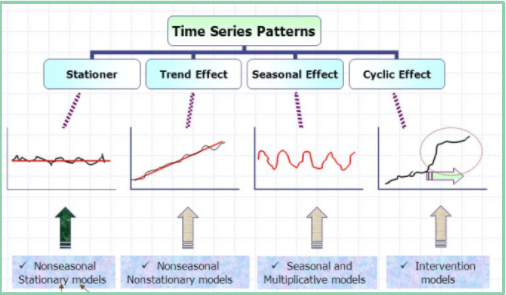


## Import Library dan Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.figsize'] = 15, 6            #agar semua plot ukurannya sama
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
!wget https://raw.githubusercontent.com/jacobstallone/Time_Series_ARIMA--Blog-and-code-/master/AirPassengers.csv

--2022-04-04 03:53:43--  https://raw.githubusercontent.com/jacobstallone/Time_Series_ARIMA--Blog-and-code-/master/AirPassengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1746 (1.7K) [text/plain]
Saving to: ‘AirPassengers.csv.1’

AirPassengers.csv.1 100%[===================>]   1.71K  --.-KB/s    in 0s      

2022-04-04 03:53:43 (10.5 MB/s) - ‘AirPassengers.csv.1’ saved [1746/1746]



In [ ]:
#Load data
data = pd.read_csv('AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


In [ ]:
len(data) #menghitung jumlah data

144

In [ ]:
#Mengubah tanggal menjadi index
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [ ]:
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [ ]:
#convert to time series:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

## Ploting data


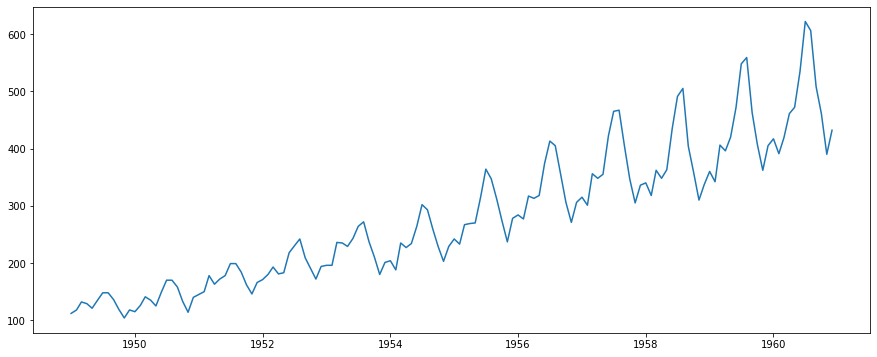

In [ ]:
plt.plot(ts)

## Uji Stasioneritas

Ho : data tidak stasioner

Ha : data stasioner

In [ ]:
#Membuat fungsi untuk uji stasioneritas
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling( window=12).mean()
    rolstd = timeseries.rolling( window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

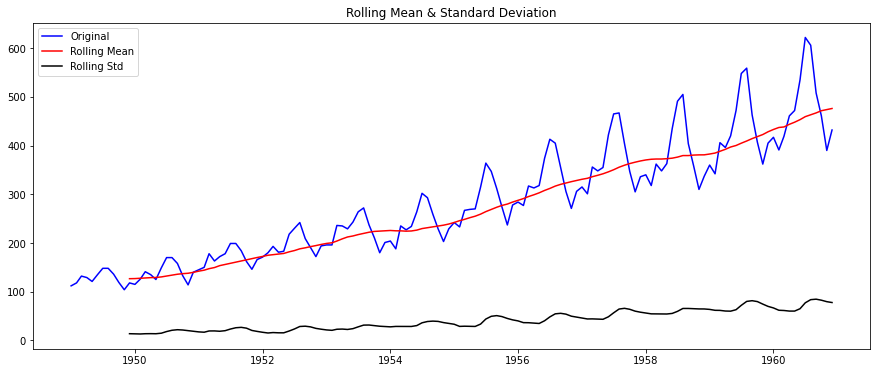

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
#Menguji data
test_stationarity(ts)

Terlihat meansnya terus berubah sehingga tidak bisa disebut stasioner. Menurut uji Dickey-Fuller, p-value = 0.99 > 0.05, sehingga Ho gagal ditolak, data tidak stasioner. Nah kita harus melakukan transformasi atau differencing

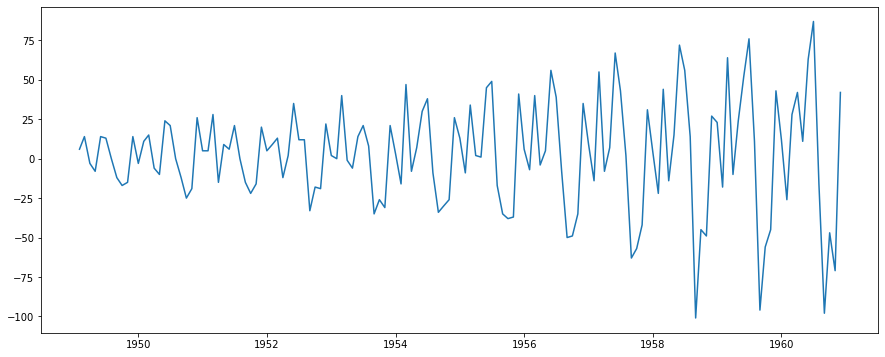

In [ ]:
#Melakukan differencing pertama
ts_diff_1 = ts - ts.shift()
ts_diff_1 = ts_diff_1.dropna()
plt.plot(ts_diff_1)

Terlihat masih belum stasioner, boleh coba differencing sekali lagi atau coba lanjutkan ke transformasi log

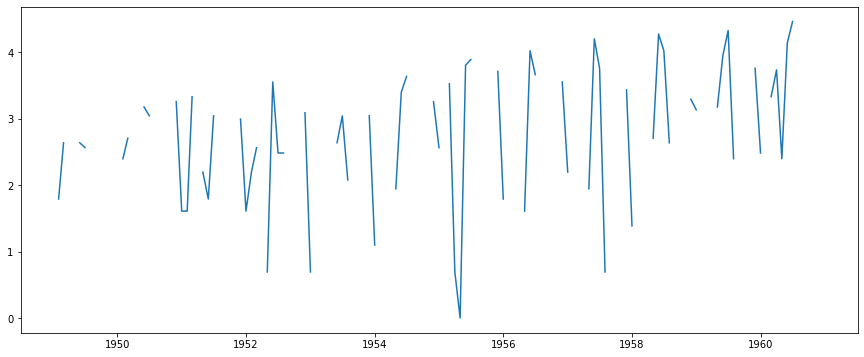

In [ ]:
#Mencoba melakukan transformasi log
ts_log_dif = np.log(ts_diff_1)
plt.plot(ts_log_dif)

Ternyata tidak lebih baik. Sekarang coba data awal yang ditransformasi log

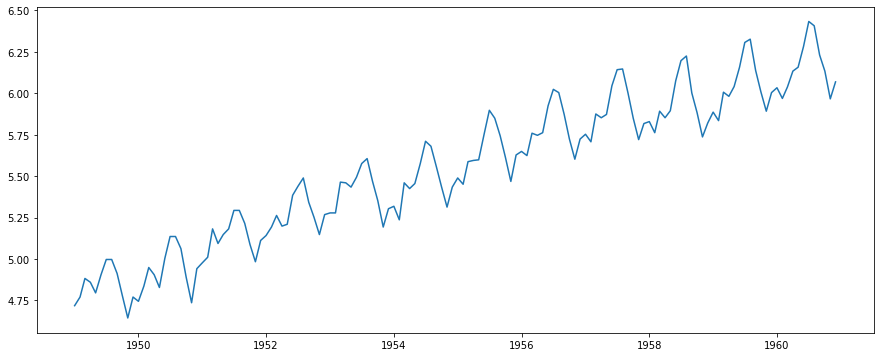

In [ ]:
#Mencoba melakukan transformasi log menggunakan data awal
ts_log = np.log(ts)
plt.plot(ts_log)

Masih belum stasioner, tetapi secara varians terlihat lebih baik. Sekarang coba data yang ini didifferencing

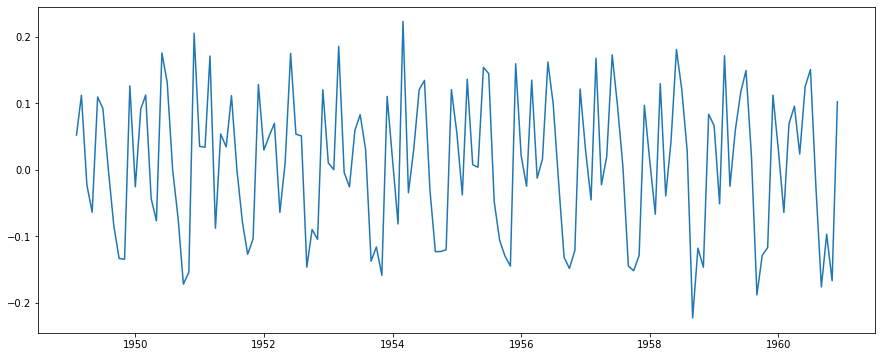

In [ ]:
#Melakukan differencing setelah transform log
ts_log_1 = ts_log - ts_log.shift()
ts_log_1 = ts_log_1.dropna()
plt.plot(ts_log_1)

Sepertinya sudah stasioner, sekarang coba uji Dickey-Fuller supaya lebih meyakinkan

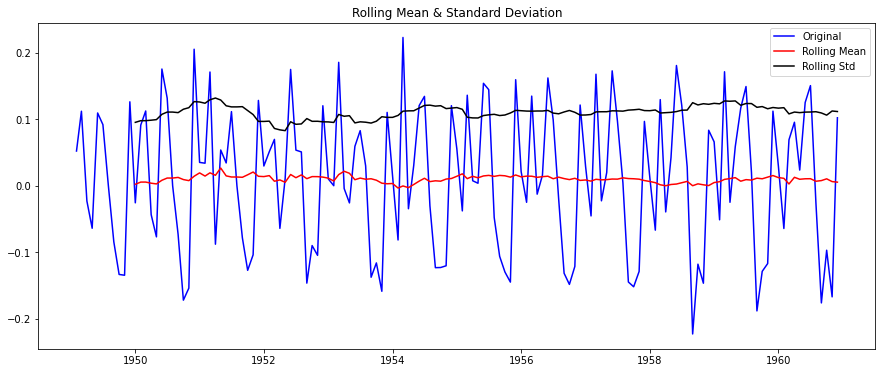

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
test_stationarity(ts_log_1)

Jika menggunakan alpha 10%, nilai p-value < alpha sehingga sudah memenuhi syarat stasioner. Jadi untuk mempersingkat waktu kita gunakan hasil ini dengan tingkat kepercayaan 90%.

## ACF & PACF

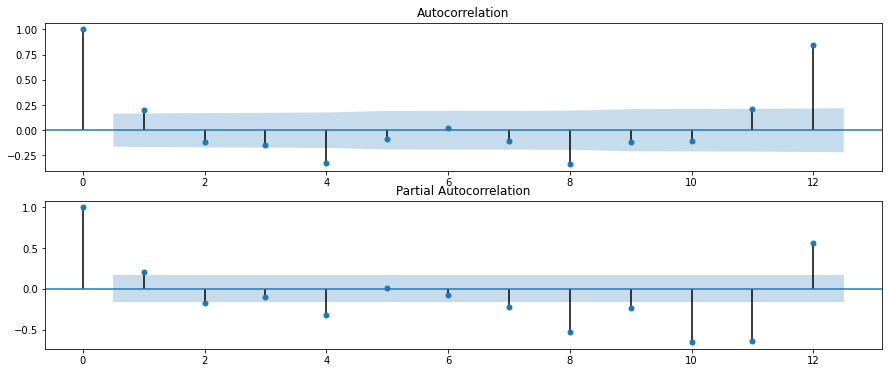

In [ ]:
plt.figure()
plt.subplot(211)
plot_acf(ts_log_1, ax=plt.gca(), lags=12)
plt.subplot(212)
plot_pacf(ts_log_1, ax=plt.gca(), lags=12)
plt.show()

Terlihat bahwa keduanya cut off lag ke-1, lalu 4, lalu 8, ini menunjukkan pola seasonal (musiman) dengan orde 4. Sehingga kemungkinan modelnya


1. ARIMA(1, 1, 1) (p=1, d=1 karena sudah differencing sekali, q=1)
2. SARIMA(1, 1, 1)4, karena mencapai max/min tiap 4

Dan kombinasi lainnya dengan p=[1, 4, 8], d=1, q=[1, 4, 8]

## Membuat model ARIMA

In [ ]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.7)               #data trainingnya 70%
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [ ]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(ts_log.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.610
ARIMA(0, 0, 1) RMSE=0.326
ARIMA(0, 1, 0) RMSE=0.114
ARIMA(0, 1, 1) RMSE=0.109
ARIMA(0, 1, 2) RMSE=0.121
ARIMA(1, 0, 0) RMSE=0.115
ARIMA(1, 0, 1) RMSE=0.110
ARIMA(1, 0, 2) RMSE=0.202
ARIMA(1, 1, 0) RMSE=0.110
ARIMA(1, 1, 1) RMSE=0.113
ARIMA(1, 1, 2) RMSE=0.101
ARIMA(2, 0, 0) RMSE=0.111
ARIMA(2, 0, 1) RMSE=0.108
ARIMA(2, 1, 0) RMSE=0.110
ARIMA(2, 1, 1) RMSE=0.098
ARIMA(2, 1, 2) RMSE=0.107
Best ARIMA(2, 1, 1) RMSE=0.098


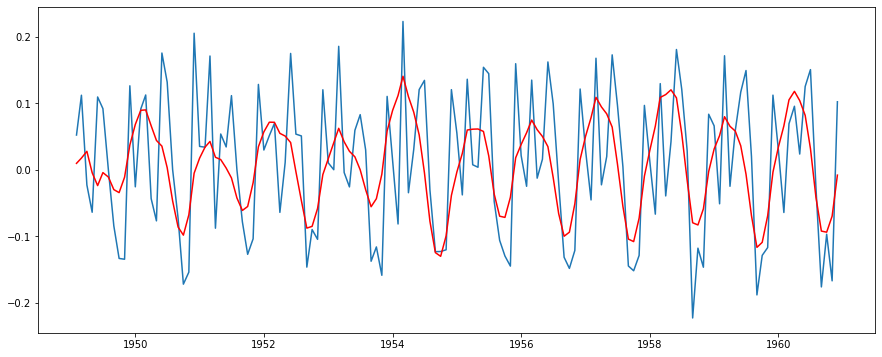

In [ ]:
model_ARIMA = ARIMA(ts_log, order=(2,1,2))
results_ARIMA = model_ARIMA.fit(disp=-1)
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
plt.plot(ts_log_1)             
plt.plot(predictions_ARIMA_diff, color='red')               #fitting dengan data yang udah difference sekali dan log

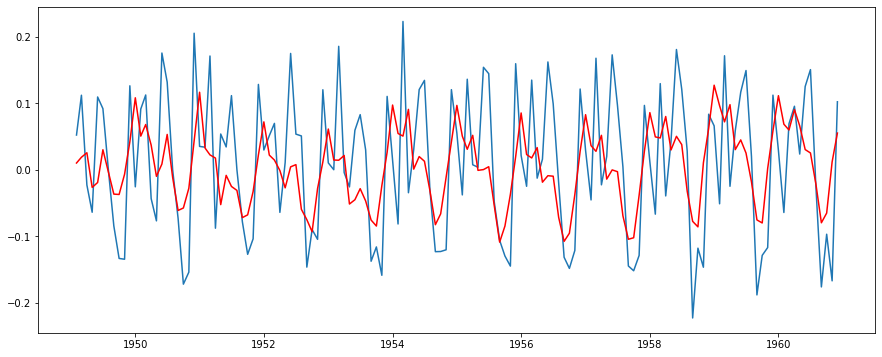

In [ ]:
model_ARIMA = ARIMA(ts_log, order=(2,1,1))
results_ARIMA = model_ARIMA.fit(disp=-1)
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
plt.plot(ts_log_1)             
plt.plot(predictions_ARIMA_diff, color='red')

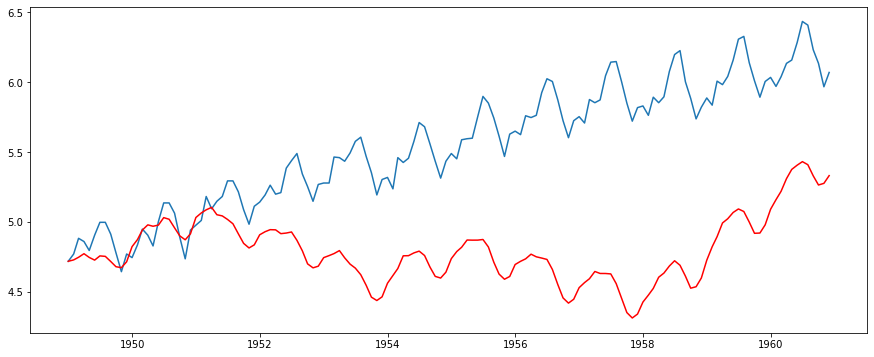

In [ ]:
predictions_ARIMA_diff_cum_sum = predictions_ARIMA_diff.cumsum()                                
predictions_ARIMA_log = pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cum_sum,fill_value=0)
plt.plot(ts_log)             
plt.plot(predictions_ARIMA_log, color='red')               #fitting dengan data yang ditransformasi log

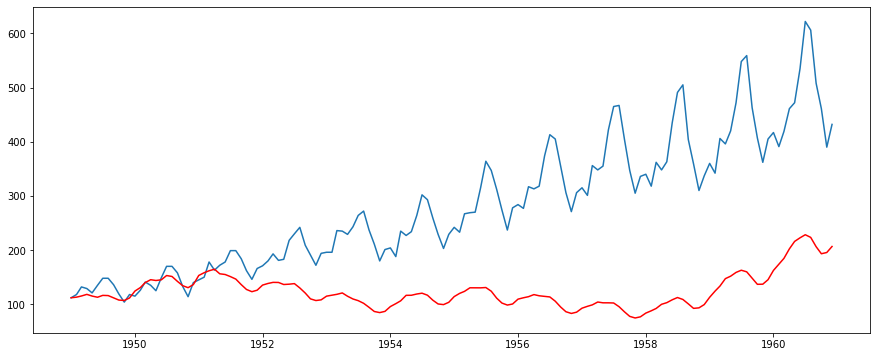

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA, color='red')                    #fitting dengan data asli

In [ ]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 140.076
Method:                       css-mle   S.D. of innovations              0.090
Date:                Mon, 04 Apr 2022   AIC                           -270.151
Time:                        03:55:15   BIC                           -255.337
Sample:                    02-01-1949   HQIC                          -264.131
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0101      0.000     23.509      0.000       0.009       0.011
ar.L1.D.#Passengers     0.9982      0.076     13.162      0.000       0.850       1.147
ar.L2.D.#Passeng

## Kombinasi Model dengan Seasonal dan Trend

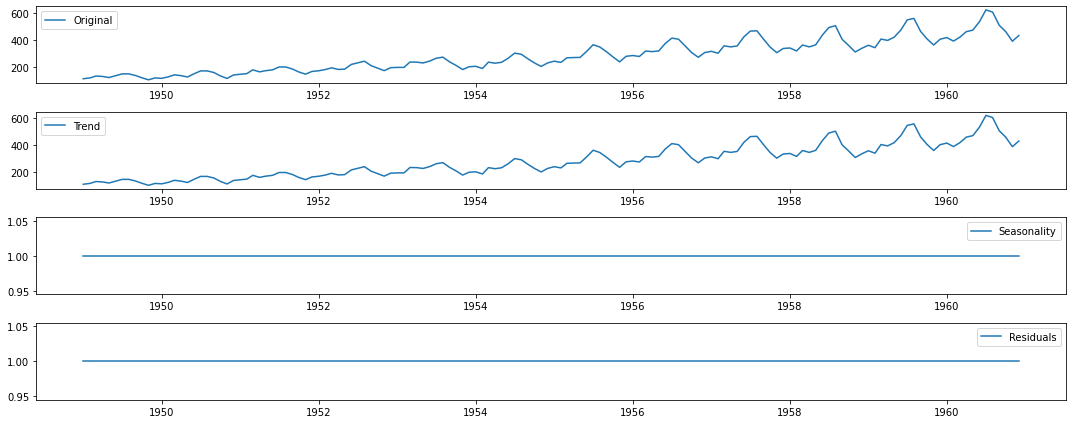

In [ ]:
decomposition = seasonal_decompose(ts, model='multiplicative', freq=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
train_size = int(len(ts) * 0.7)               #data trainingnya 70%
train, test = ts_log[:train_size], ts_log[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in range(len(test)):
		model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,4))
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])

# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)

0.09648211639549847


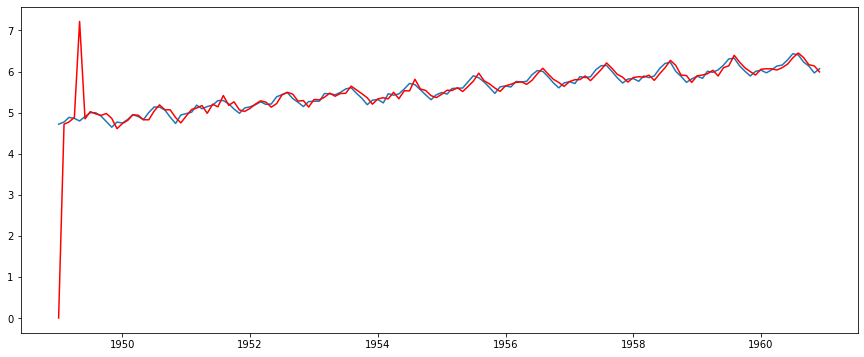

In [ ]:
#Bikin model SARIMA
model_sarima = SARIMAX(ts_log, order=(1,1,1), seasonal_order=(1,1,1,4))
results_SARIMA = model_sarima.fit(disp=-1)
predictions_SARIMA_diff = pd.Series(results_SARIMA.fittedvalues,copy=True)
plt.plot(ts_log)             
plt.plot(predictions_SARIMA_diff, color='red')               #fitting dengan data log

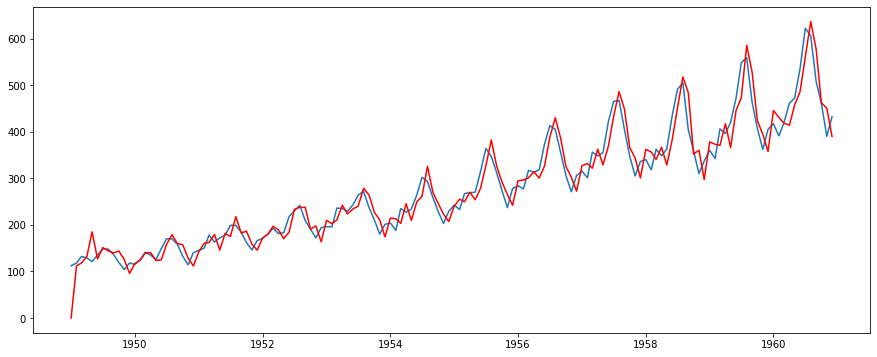

In [ ]:
#SARIMA + trend untuk data asli
model_sarima_trend = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,4), trend='t')
results_SARIMA_t = model_sarima_trend.fit(disp=-1)
predictions_SARIMA_diff_t = pd.Series(results_SARIMA_t.fittedvalues,copy=True)
plt.plot(ts)             
plt.plot(predictions_SARIMA_diff_t, color='red')               #fitting dengan data asli

In [ ]:
print(results_SARIMA_t.summary())

                                 Statespace Model Results                                
Dep. Variable:                       #Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -668.073
Date:                           Mon, 04 Apr 2022   AIC                           1348.146
Time:                                   03:57:01   BIC                           1365.753
Sample:                               01-01-1949   HQIC                          1355.301
                                    - 12-01-1960                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0009      0.003      0.297      0.767      -0.005       0.007
ar.L1         -0.0632      0.235     -0.269

## Membuat prediksi

In [ ]:
#dengan model ARIMA(2,1,2)
predict_dif = results_ARIMA.predict(start=144,end=156)
predictions_dif_cum_sum = predict_dif.cumsum()                   #prediksi differencingnya
pred_log = [ts_log[-1]]
for i, j in enumerate(predictions_dif_cum_sum):                  #prediksi data lognya
  a = pred_log[i] + j
  pred_log.append(a)
predict_exp = pd.Series(np.exp(pred_log[1:]), index=predict_dif.index)  #prediksi data aslinya
print(predict_exp)

1961-01-01      491.144381
1961-02-01      610.962309
1961-03-01      791.788826
1961-04-01     1034.244821
1961-05-01     1344.351576
1961-06-01     1740.544910
1961-07-01     2258.597490
1961-08-01     2954.600997
1961-09-01     3909.042144
1961-10-01     5234.944383
1961-11-01     7092.529641
1961-12-01     9713.301878
1962-01-01    13437.897013
Freq: MS, dtype: float64


In [ ]:
#prediksi dengan SARIMA+trend
pred_2 = results_SARIMA_t.predict(start=144,end=156)
print(pred_2)

1961-01-01    470.755861
1961-02-01    489.364628
1961-03-01    539.651560
1961-04-01    535.980021
1961-05-01    505.436377
1961-06-01    498.662502
1961-07-01    500.188271
1961-08-01    515.028351
1961-09-01    512.504974
1961-10-01    516.073210
1961-11-01    537.353162
1961-12-01    544.866848
1962-01-01    531.190077
Freq: MS, dtype: float64


#Tugas Kelompok 2 Part 1
1. Tim akan dibagi berdasarkan breakout room di zoom dengan masing2 anggota 4-5 mahasiswa
2. Mencari dataset time series yang dimodelkan dengan pendekatan statistik
3. Dibuat dalam bentuk ipynb (file coding) dan ppt yang berisikan dataset, model yang digunakan dan step by step syntax coding, hingga insight yang diperoleh (kesimpulan)
4. Deadline Tugas Jumat, 15 April 2022 melalui link yg akan diupdate kemudian